In [2]:
import os
from glob import glob
import random
import time
#import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16


In [3]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [5]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('..', '/home/ravisankar/Desktop/DesktopFiles/finalyear projects ideas/state-farm-distracted-driver-detection/imgs', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('..', '/home/ravisankar/Desktop/DesktopFiles/finalyear projects ideas/state-farm-distracted-driver-detection/imgs', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [6]:
img_rows = 64
img_cols = 64
color_type = 1

In [7]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:32<04:53, 32.60s/it]

Loading directory c1


 20%|██        | 2/10 [01:48<06:05, 45.63s/it]

Loading directory c2


 30%|███       | 3/10 [02:54<06:01, 51.70s/it]

Loading directory c3


 40%|████      | 4/10 [04:12<05:56, 59.46s/it]

Loading directory c4


 50%|█████     | 5/10 [05:39<05:38, 67.71s/it]

Loading directory c5


 60%|██████    | 6/10 [06:45<04:29, 67.39s/it]

Loading directory c6


 70%|███████   | 7/10 [07:13<02:46, 55.46s/it]

Loading directory c7


 80%|████████  | 8/10 [07:21<01:22, 41.16s/it]

Loading directory c8


 90%|█████████ | 9/10 [07:27<00:30, 30.83s/it]

Loading directory c9


100%|██████████| 10/10 [07:38<00:00, 24.68s/it]

Data Loaded in 458.15490531921387 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [8]:


nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')



  0%|          | 199/79726 [00:00<03:36, 367.51it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


In [9]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("../home/ravisankar/Desktop/DesktopFiles/finalyear projects ideas/state-farm-distracted-driver-detection/imgs/train/*"))]
test_files_size = len(np.array(glob(os.path.join('..', '/home/ravisankar/Desktop/DesktopFiles/finalyear projects ideas/state-farm-distracted-driver-detection/imgs', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 0 total training categories.
There are 4485 validation images.
There are 79726 test images.


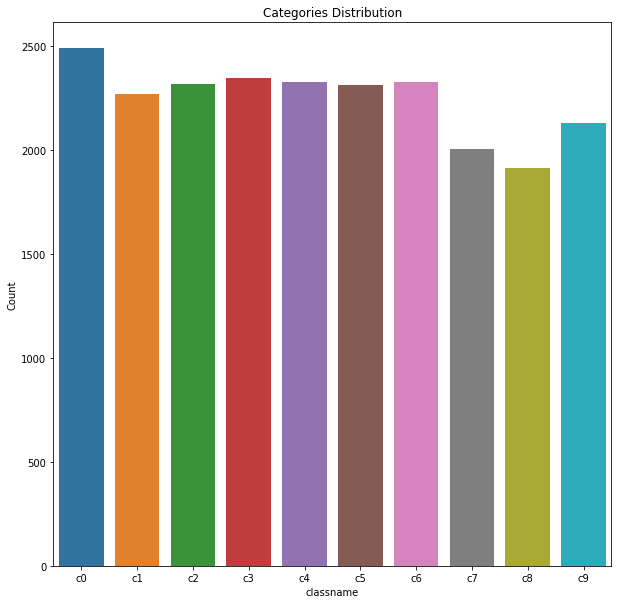

In [10]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [11]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id


,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

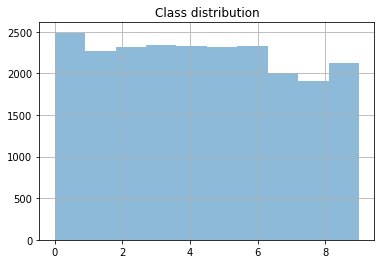

In [12]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()


In [13]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


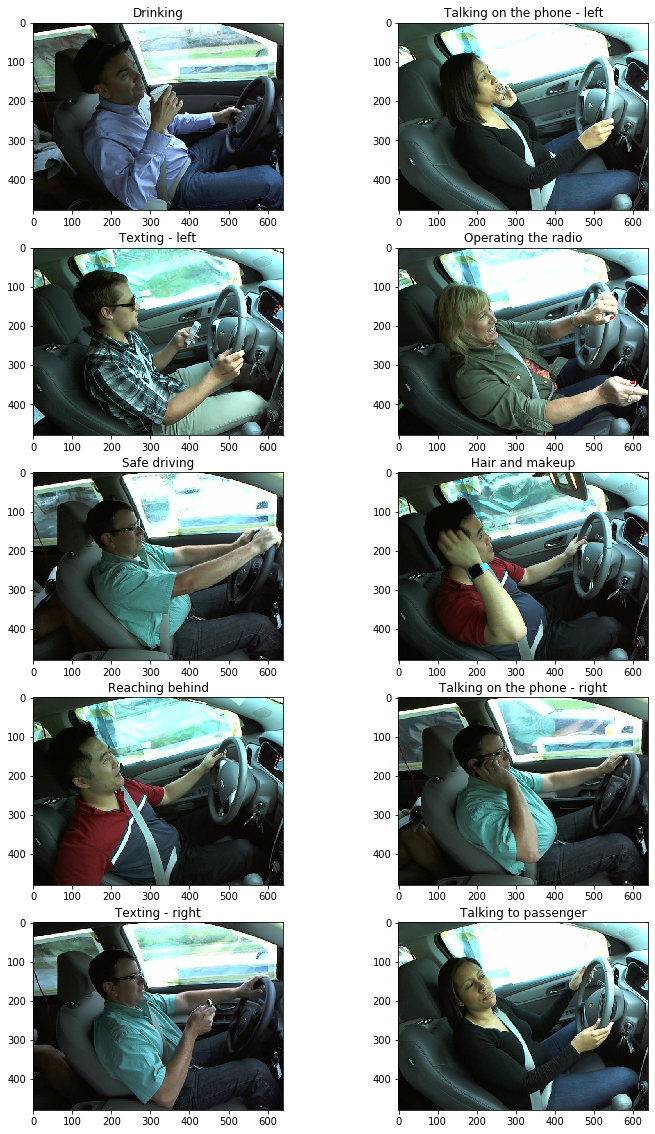

In [14]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/home/ravisankar/Desktop/DesktopFiles/finalyear projects ideas/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])


In [14]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('prediction_submissions'):
        os.mkdir('prediction_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('prediction_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file


In [15]:
batch_size = 40
nb_epoch = 10

In [16]:


!rm -f saved_models/weights_best_vanilla.hdf5



In [17]:


models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]



In [18]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [19]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
________________________________________________

In [20]:
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 688s 38ms/step - loss: 14.2963 - accuracy: 0.1128 - val_loss: 14.4542 - val_accuracy: 0.1032

Epoch 00001: val_loss improved from inf to 14.45418, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10
17939/17939 [==============================] - 16088s 897ms/step - loss: 14.2968 - accuracy: 0.1130 - val_loss: 14.4542 - val_accuracy: 0.1032

Epoch 00002: val_loss did not improve from 14.45418
Epoch 3/10
17939/17939 [==============================] - 529s 30ms/step - loss: 14.2977 - accuracy: 0.1129 - val_loss: 14.4542 - val_accuracy: 0.1032

Epoch 00003: val_loss did not improve from 14.45418
Epoch 00003: early stopping


In [21]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')#
ModelCheckpoint(filepath='saved_models/weights_1.hdf5 ',#
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)

In [22]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [23]:


plot_train_history(history_v1)



KeyError: 'acc'

In [23]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()


In [24]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

4485/4485 [==============================] - 30s 7ms/step
Score:  [14.454175898489213, 0.10323300212621689]


In [3]:
plot_test_class(model_v1, test_files, 30)

NameError: name 'plot_test_class' is not defined

In [1]:
plot_test_class(model_v1, test_files, 121)

NameError: name 'plot_test_class' is not defined

In [6]:
plot_test_class(model_v1, test_files, 23)

NameError: name 'plot_test_class' is not defined

In [27]:
!rm -f saved_models/weights_best_vanilla.hdf5


In [ ]:
#!rm -f saved_models/weights_best_vanilla.hdf5


In [28]:
def create_model_v2():
    # Optimised Vanilla CNN model
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model


In [29]:
model_v2 = create_model_v2()

# More details about the layers
model_v2.summary()

# Compiling the model
model_v2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 64)       

In [30]:


# Training the Vanilla Model
history_v2 = model_v2.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)



Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 679s 38ms/step - loss: 1.2305 - accuracy: 0.5916 - val_loss: 0.6882 - val_accuracy: 0.7975

Epoch 00001: val_loss improved from 14.45418 to 0.68821, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10
17939/17939 [==============================] - 680s 38ms/step - loss: 0.3396 - accuracy: 0.8960 - val_loss: 0.1827 - val_accuracy: 0.9496

Epoch 00002: val_loss improved from 0.68821 to 0.18274, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/10
17939/17939 [==============================] - 686s 38ms/step - loss: 0.2107 - accuracy: 0.9353 - val_loss: 0.1643 - val_accuracy: 0.9545

Epoch 00003: val_loss improved from 0.18274 to 0.16425, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 4/10
17939/17939 [==============================] - 680s 38ms/step - loss: 0.1512 - accuracy: 0.9542 - val_loss: 0.2569 - val_accuracy: 0.9307

Epoch 00004: val_

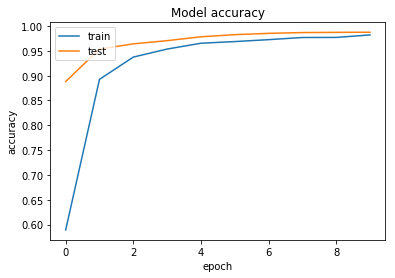

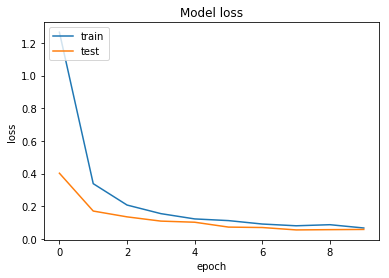

In [31]:


plot_train_history(history_v2)



In [31]:


model_v2.load_weights('saved_models/weights_best_vanilla.hdf5')
ModelCheckpoint(filepath='saved_models/weights_2.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)



In [32]:


score = model_v2.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

y_pred = model_v2.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)
print('Score log loss:', score)



4485/4485 [==============================] - 34s 8ms/step
Score:  [0.051423980690069766, 0.9877368807792664]
4485/4485 [==============================] - 37s 8ms/step
Score log loss: 0.0514239251812082


In [33]:


score = model_v2.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

y_pred = model_v2.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)
print('Score log loss:', score)



4485/4485 [==============================] - 39s 9ms/step
Score:  [0.051423980690069766, 0.9877368807792664]
4485/4485 [==============================] - 38s 8ms/step
Score log loss: 0.0514239251812082


1/1 [==============================] - 0s 13ms/step
Y prediction: [[9.1500815e-06 3.0470789e-11 2.4200772e-09 8.6701375e-01 5.4805446e-02
  7.8037120e-02 2.1123192e-09 6.0422855e-07 3.3767970e-05 1.0005415e-04]]
Predicted: Texting - left


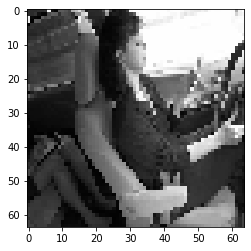

In [85]:
plot_test_class(model_v2, test_files, 77) # The model really performs good

1/1 [==============================] - 0s 12ms/step
Y prediction: [[1.36220694e-06 1.83932036e-12 1.80052034e-12 8.72051806e-11
  1.04923015e-10 9.99998569e-01 1.29909319e-10 9.97003687e-18
  2.74864468e-13 1.78030191e-07]]
Predicted: Operating the radio


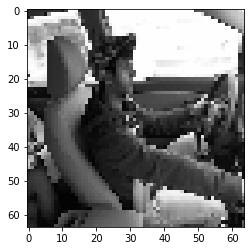

In [83]:
plot_test_class(model_v2, test_files, 75) 

1/1 [==============================] - 0s 14ms/step
Y prediction: [[3.0875970e-20 2.1470303e-19 6.7543071e-20 8.0736877e-25 6.1825329e-22
  6.2707696e-23 1.8008437e-18 1.0000000e+00 1.3909230e-15 3.3655084e-19]]
Predicted: Reaching behind


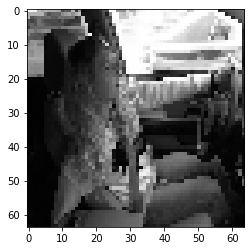

In [72]:
plot_test_class(model_v2, test_files, 107) #!rm -f saved_models/weights_best_vanilla.hdf5

In [42]:

#OVERFITTING THR MODEL

# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)



In [43]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)


17939
4485


In [40]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_v2.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)


Epoch 1/5
448/448 [==============================] - 645s 1s/step - loss: 1.3180 - acc: 0.6068 - val_loss: 5.7805 - val_acc: 0.1237

Epoch 00001: val_acc improved from -inf to 0.12366, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/5
448/448 [==============================] - 643s 1s/step - loss: 0.7142 - acc: 0.7602 - val_loss: 0.2596 - val_acc: 0.9278

Epoch 00002: val_acc improved from 0.12366 to 0.92778, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/5
448/448 [==============================] - 68201s 152s/step - loss: 0.5376 - acc: 0.8287 - val_loss: 0.3585 - val_acc: 0.9375

Epoch 00003: val_acc improved from 0.92778 to 0.93746, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 4/5
448/448 [==============================] - 653s 1s/step - loss: 0.4565 - acc: 0.8584 - val_loss: 0.2293 - val_acc: 0.9539

Epoch 00004: val_acc improved from 0.93746 to 0.95388, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 5/5
448/448 [========

In [44]:
model_v2.load_weights('saved_models/weights_best_vanilla.hdf5')

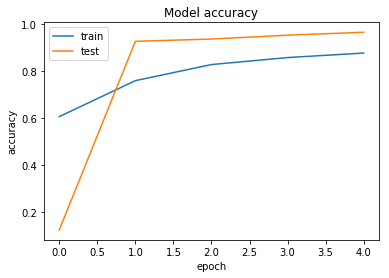

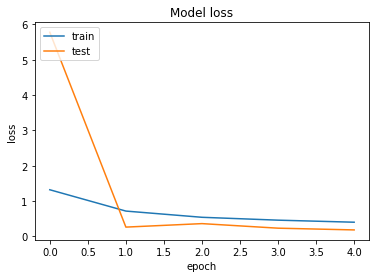

In [42]:


plot_train_history(history_v3)



In [45]:


# Evaluate the performance of the new model
score = model_v2.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])



Test Score: 14.103334426879883
Test Accuracy: 0.10401785373687744


In [6]:


plot_test_class(model_v2, test_files, 181)



NameError: name 'plot_test_class' is not defined

1/1 [==============================] - 0s 10ms/step
Y prediction: [[3.95868719e-02 1.16372485e-06 1.43047961e-04 4.69134829e-05
  9.57350969e-01 2.95145605e-06 1.34393427e-04 1.16825014e-07
  3.74381983e-04 2.35918094e-03]]
Predicted: Talking on the phone - left


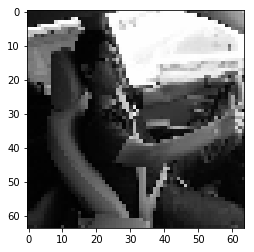

In [125]:
plot_test_class(model_v2, test_files, 79) 


1/1 [==============================] - 0s 14ms/step
Y prediction: [[3.1464564e-11 9.3127660e-08 6.2361693e-08 9.5179525e-15 3.8761104e-07
  2.9444767e-12 9.9999452e-01 1.2184723e-11 4.8580541e-06 3.1930356e-09]]
Predicted: Drinking


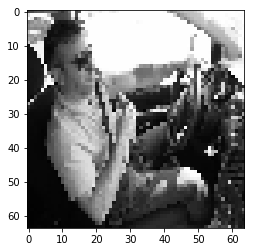

In [126]:
plot_test_class(model_v2, test_files, 88) 

In [1]:
plot_test_class(model_v2, test_files, 56) 


NameError: name 'plot_test_class' is not defined

In [47]:


predictions = model_v2.predict(test_files, batch_size=batch_size)
FileLink(create_submission(predictions, test_targets, score[0]))



/home/ravisankar/Desktop/DesktopFiles/finalyear projects ideas/state-farm-distracted-driver-detection/prediction_submissions/submission_14.103334426879883_2020-01-06-00-38.csv

In [49]:


#!rm -f saved_models/weights_best_vanilla.hdf5



In [91]:
from keras.applications.vgg16 import VGG16

In [92]:

def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model = VGG16(weights="imagenet", include_top=False)
#/home/ravisankar/Downloads/vgg16_weights.h5
    # Freeze all layers of the pre-trained model
    for layer in vgg16_model.layers:
        layer.trainable = False
        
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    model = Model(input = vgg16_model.input, output = predictions)
    
    return model

In [94]:
from keras_applications import vgg16

In [95]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

                  

Loading network...


ValueError: unknown url type: '.keras/applications/vgg16_weights.h5'

In [63]:
for i in range(10):
    training_generator = train_datagen.flow_from_directory('../home/ravisankar/Desktop/DesktopFiles/''finalyear projects ideas''/state-farm-distracted-driver-detection/imgs/train', 
                                                     target_size = (img_rows, img_cols), 
                                                     batch_size = batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical', subset="training")

    validation_generator = test_datagen.flow_from_directory('../home/ravisankar/Desktop/DesktopFiles/finalyear projects ideas/state-farm-distracted-driver-detection/imgs/train', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

FileNotFoundError: [Errno 2] No such file or directory: '../home/ravisankar/Desktop/DesktopFiles/finalyear projects ideas/state-farm-distracted-driver-detection/imgs/train'

In [69]:
#!rm -f saved_models/weights_best_vgg16.hdf5


In [64]:
# Training the Vanilla Model
checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v4 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         class_weight='auto',
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

NameError: name 'model_vgg16' is not defined

In [65]:


model_vgg16.load_weights('saved_models/vgg19_weights_tf_dim_ordering_tf_kernels.h5.hdf5')



NameError: name 'model_vgg16' is not defined

In [66]:
plot_train_history(history_v4)


NameError: name 'history_v4' is not defined

In [67]:
def plot_vgg16_test_class(model, test_files, image_number):
    img_brute = test_files[image_number]

    im = cv2.resize(cv2.cvtColor(img_brute, cv2.COLOR_BGR2RGB), (img_rows,img_cols)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    img_display = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_display, cmap='gray')

    y_preds = model.predict(im, batch_size=batch_size, verbose=1)
    print(y_preds)
    y_prediction = np.argmax(y_preds)
    print('Y Prediction: {}'.format(y_prediction))
    print('Predicted as: {}'.format(activity_map.get('c{}'.format(y_prediction))))
    
    plt.show()

In [68]:
plot_vgg16_test_class(model_vgg16, test_files, 133) # Texting left


NameError: name 'model_vgg16' is not defined

In [69]:
plot_vgg16_test_class(model_vgg16, test_files, 23) # Texting left


NameError: name 'model_vgg16' is not defined

In [70]:
plot_vgg16_test_class(model_vgg16, test_files, 88) # Hair

NameError: name 'model_vgg16' is not defined

In [71]:
# Evaluate the performance of the new model
score = model_vgg16.evaluate_generator(validation_generator, nb_validation_samples // batch_size, verbose = 1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

NameError: name 'model_vgg16' is not defined

In [ ]:
#https://www.kaggle.com/ismailchaida/cnn-to-detect-driver-actions